$$ \frac{\partial}{\partial\vartheta} \frac{(\iota-\partial\lambda_\varphi)g_{\vartheta\varphi}+(1+\partial\lambda_\vartheta)g_{\varphi\varphi}}{\sqrt{g}} 
= \frac{\partial}{\partial\varphi} \frac{(\iota-\partial\lambda_\varphi)g_{\vartheta\vartheta}+(1+\partial\lambda_\vartheta)g_{\vartheta\varphi}}{\sqrt{g}} $$

令 $P = (\iota-\partial\lambda_\varphi)g_{\vartheta\varphi}+(1+\partial\lambda_\vartheta)g_{\varphi\varphi}$，$Q = (\iota-\partial\lambda_\varphi)g_{\vartheta\vartheta}+(1+\partial\lambda_\vartheta)g_{\vartheta\varphi}$

$$ \sqrt{g}\left( \frac{\partial P}{\partial\vartheta}-\frac{\partial Q}{\partial\varphi} \right)
= P\frac{\partial\sqrt{g}}{\partial\vartheta} - Q\frac{\partial\sqrt{g}}{\partial\varphi} $$

In [41]:
import numpy as np 
import dcs.vmec 
from dcs.toroidalField import ToroidalField, derivatePol, derivateTor,changeResolution
from dcs.geometry import Surface_cylindricalAngle
import matplotlib.pyplot as plt
try:
    import matplotlib
    matplotlib.rcParams['text.usetex'] = True
except:
    pass

In [42]:
vmeclib = dcs.vmec.VMECOut("../arbitrarySurface_VMECCases/wout_QAS.nc")
# vmeclib = dcs.vmec.VMECOut("../arbitrarySurface_VMECCases/wout_heliotron.nc")
# vmeclib = dcs.vmec.VMECOut("../arbitrarySurface_VMECCases/wout_DIII-D.nc")

In [43]:
_jacobian = vmeclib.getJacobian() 
nfp = _jacobian.nfp
# mpol = 2*_jacobian.mpol
# ntor = 2*_jacobian.ntor
mpol = _jacobian.mpol
ntor = _jacobian.ntor
_surface, _lambdaField = vmeclib.getSurface()
jacobian = changeResolution(_jacobian, mpol=mpol, ntor=ntor)
lambdaField = changeResolution(_lambdaField, mpol=mpol, ntor=ntor)
surface = Surface_cylindricalAngle(
    changeResolution(_surface.r, mpol=mpol, ntor=ntor), 
    changeResolution(_surface.z, mpol=mpol, ntor=ntor)
)


In [44]:
# iota = vmeclib.iotaf[-1] 

bSupU, bSupV = vmeclib.getBsup() 
jacobianBsupU = (jacobian*bSupU) 
jacobianBsupV = (jacobian*bSupV) 
iota = jacobianBsupU.reArr[0]/jacobianBsupV.reArr[0] 

In [45]:
g_thetatheta, g_thetazeta, g_zetazeta = surface.metric 
fieldP = (
    (ToroidalField.constantField(iota, nfp, mpol, ntor) - derivateTor(lambdaField)) * g_thetazeta +
    (ToroidalField.constantField(1, nfp, mpol, ntor) + derivatePol(lambdaField)) * g_zetazeta
)
fieldQ = (
    (ToroidalField.constantField(iota, nfp, mpol, ntor) - derivateTor(lambdaField)) * g_thetatheta +
    (ToroidalField.constantField(1, nfp, mpol, ntor) + derivatePol(lambdaField)) * g_thetazeta
)
fieldD = derivatePol(fieldP) - derivateTor(fieldQ)

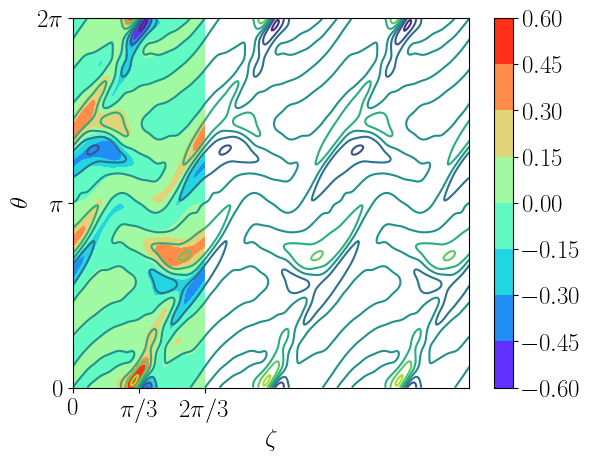

In [46]:
basisTheta, basisZeta = np.linspace(0, 2*np.pi, 500), np.linspace(0, 2*np.pi, 500)
gridBasisZeta, gridBasisTheta = np.meshgrid(basisZeta, basisTheta)

fig, ax = plt.subplots()
ax.contour(
    gridBasisZeta, gridBasisTheta, 
    (
        (fieldP*derivatePol(jacobian)) - fieldQ*derivateTor(jacobian)
    ).getValue(gridBasisTheta,gridBasisZeta)
)
(jacobian*fieldD).plot_plt(ax=ax, fig=fig, onePeriod=True) 

Text(0.5, 0, '$\\vartheta$')

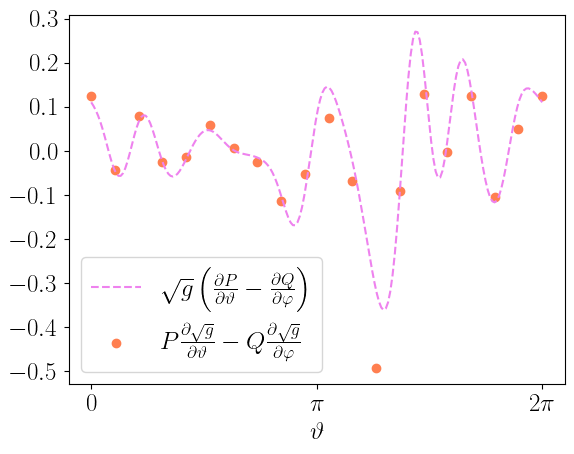

In [48]:
fig, ax = plt.subplots()
zetaValue = np.pi/6
ax.plot(
    np.linspace(0, 2*np.pi, 200), 
    ((fieldP*derivatePol(jacobian)) - fieldQ*derivateTor(jacobian)).getValue(np.linspace(0, 2*np.pi, 200), np.ones(200)*zetaValue).flatten(), 
    label = r"$\sqrt{g}\left( \frac{\partial P}{\partial\vartheta}-\frac{\partial Q}{\partial\varphi} \right)$", 
    ls = "--",
    color = "violet"
)
ax.scatter(
    np.linspace(0, 2*np.pi, 20),
    (jacobian.getValue(np.linspace(0,2*np.pi,20), np.zeros(20)) * fieldD.getValue(np.linspace(0,2*np.pi,20), np.ones(20)*zetaValue)).flatten(),
    label = r"$P\frac{\partial\sqrt{g}}{\partial\vartheta} - Q\frac{\partial\sqrt{g}}{\partial\varphi}$",
    color = "coral"
)
ax.legend(fontsize=18)
xValues = np.linspace(0, 2*np.pi, 3)
ax.set_xticks(xValues)
ax.set_xticklabels(["$0$", "$\pi$", "$2\pi$"], fontsize=18)
plt.yticks(fontsize=18)
ax.set_xlabel(r"$\vartheta$", fontsize=18)